# System Level Quantiziation

--- 🔬 Running KV Cache VRAM Simulation (No LLM needed) ---

--- Simulation Summary ---
Simulated Sequence Length: 1024 tokens
Calculated FP16 KV Cache size: 0.176 GB
Calculated INT8 KV Cache size:  0.088 GB
✅ VRAM saved on cache: 0.088 GB (a 50% reduction)

📊 Graph saved as 'vram_simulation.png'


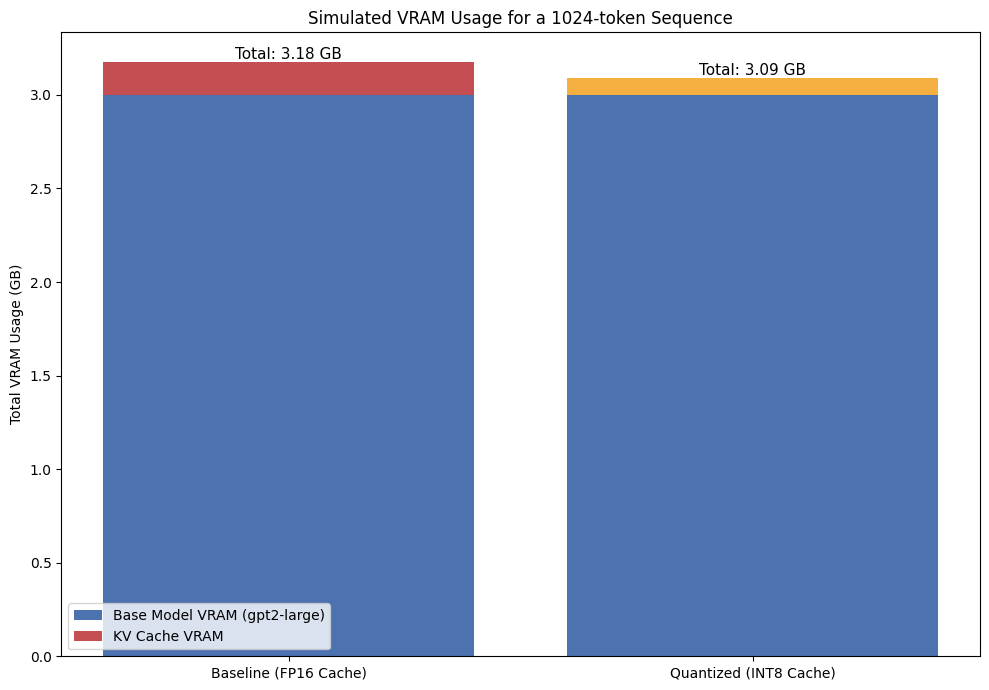

In [17]:
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
# We define the gpt2-large architecture parameters manually.
GPT2_LARGE_CONFIG = {
    "num_layers": 36,
    "hidden_size": 1280, # This is equivalent to num_heads * head_size
    # An approximate size of the gpt2-large model weights in FP16.
    "base_model_vram_gb": 3.0 
}
GENERATION_LENGTH = 1024
BATCH_SIZE = 1 # We are simulating a single prompt

def calculate_kv_cache_vram(config, sequence_length, batch_size, bytes_per_element):
    """
    Calculates the theoretical VRAM usage for a KV cache based on model architecture.
    """
    # The formula to calculate the total number of elements in the cache
    num_elements = batch_size * sequence_length * config["num_layers"] * 2 * config["hidden_size"]
    
    # Calculate the total size in bytes
    total_bytes = num_elements * bytes_per_element
    
    # Convert bytes to gigabytes
    total_gb = total_bytes / (1024**3)
    
    return total_gb

def main():
    print("--- 🔬 Running KV Cache VRAM Simulation (No LLM needed) ---")

    # --- Step 1: Calculate VRAM for a standard FP16 KV Cache ---
    # FP16 uses 2 bytes per element
    fp16_vram_cache = calculate_kv_cache_vram(
        GPT2_LARGE_CONFIG,
        GENERATION_LENGTH,
        BATCH_SIZE,
        bytes_per_element=2
    )

    # --- Step 2: Calculate VRAM for a quantized INT8 KV Cache ---
    # INT8 uses 1 byte per element
    int8_vram_cache = calculate_kv_cache_vram(
        GPT2_LARGE_CONFIG,
        GENERATION_LENGTH,
        BATCH_SIZE,
        bytes_per_element=1
    )
    
    memory_saved = fp16_vram_cache - int8_vram_cache
    
    print("\n--- Simulation Summary ---")
    print(f"Simulated Sequence Length: {GENERATION_LENGTH} tokens")
    print(f"Calculated FP16 KV Cache size: {fp16_vram_cache:.3f} GB")
    print(f"Calculated INT8 KV Cache size:  {int8_vram_cache:.3f} GB")
    print(f"✅ VRAM saved on cache: {memory_saved:.3f} GB (a 50% reduction)")

    # --- Step 3: Plot the simulated results ---
    labels = ['Baseline (FP16 Cache)', 'Quantized (INT8 Cache)']
    cache_sizes = [fp16_vram_cache, int8_vram_cache]
    base_model_size_gb = GPT2_LARGE_CONFIG["base_model_vram_gb"]
    base_model_size_bars = [base_model_size_gb, base_model_size_gb]

    plt.figure(figsize=(10, 7))
    # Plot the base model VRAM (bottom part of the stack)
    plt.bar(labels, base_model_size_bars, label='Base Model VRAM (gpt2-large)', color='#4c72b0')
    # Plot the KV cache VRAM on top
    plt.bar(labels, cache_sizes, bottom=base_model_size_bars, label='KV Cache VRAM', color=['#c44e52', '#f5b041'])

    # Add text labels for total VRAM
    total_fp16 = base_model_size_gb + fp16_vram_cache
    total_int8 = base_model_size_gb + int8_vram_cache
    plt.text(labels[0], total_fp16, f'Total: {total_fp16:.2f} GB', ha='center', va='bottom', fontsize=11)
    plt.text(labels[1], total_int8, f'Total: {total_int8:.2f} GB', ha='center', va='bottom', fontsize=11)

    plt.ylabel('Total VRAM Usage (GB)')
    plt.title(f'Simulated VRAM Usage for a {GENERATION_LENGTH}-token Sequence')
    plt.legend()
    plt.tight_layout()
    plt.savefig("vram_simulation.png")
    print("\n📊 Graph saved as 'vram_simulation.png'")
    plt.show()


if __name__ == "__main__":
    main()